# 白石のモジュール検出の結果を使用する

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# モジュールのインポート
import os
import json
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
import pickle

In [3]:
# 自作モジュール
sys.path.append("../src")
import module_extraction
from module_extraction import Filters, Modules
import utils

分析対象の指定

In [4]:
# 白石のモジュール検出の結果を指定する
# -- 元の個別画像 --
input_img_path = '../images/ortho/白石のモジュール検出結果/module_issue/0106_half_image.png'
# input_img_path = '../images/ortho/白石のモジュール検出結果/module_issue/0081_half_image.png'
# -- マスク画像 --
input_img_mask_path = '../images/ortho/白石のモジュール検出結果/module_issue/0106_half_pred.png'
# input_img_mask_path = '../images/ortho/白石のモジュール検出結果/module_issue/0081_half_pred.png'

In [5]:
# 出力先フォルダの作成
output_dir_path = "../outputs/" + input_img_path.split("/")[-2] + "/" + input_img_path.split("/")[-1][:-4]
print(output_dir_path)
os.makedirs(output_dir_path,exist_ok=True)

../outputs/module_issue/0106_half_image


フィルタの適用

In [6]:
filters = Filters()

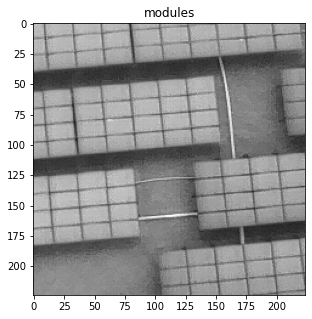

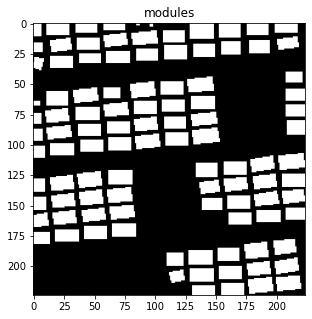

In [7]:
# 元画像
img_org = cv2.imread(input_img_path, 0)
utils.show_img({"modules":img_org},cmap="gray", vmax=255, figsize=(5,5))
# マスク画像
img_con = cv2.imread(input_img_mask_path, 0)
utils.show_img({"modules":img_con},cmap="gray", vmax=255, figsize=(5,5))

In [8]:
# マスク画像のマトリックスを指定する
with open('../images/ortho/白石のモジュール検出結果/module_issue/0106_module_contours.pkl', 'rb') as pkl:
    candidate_module_contours = pickle.load(pkl)
    print(candidate_module_contours)
# with open('../images/ortho/白石のモジュール検出結果/module_issue/0081_module_contours.pkl', 'rb') as pkl:
#     candidate_module_contours = pickle.load(pkl)
#     print(candidate_module_contours)

[array([[131, 216],
       [149, 216],
       [149, 223],
       [131, 223]]), array([[155, 214],
       [173, 214],
       [173, 223],
       [155, 223]]), array([[177, 211],
       [196, 209],
       [197, 220],
       [178, 222]]), array([[200, 209],
       [219, 208],
       [220, 218],
       [201, 220]]), array([[112, 205],
       [123, 203],
       [124, 211],
       [114, 213]]), array([[129, 202],
       [148, 202],
       [148, 212],
       [129, 212]]), array([[153, 200],
       [171, 200],
       [171, 210],
       [153, 210]]), array([[176, 198],
       [194, 196],
       [195, 206],
       [177, 207]]), array([[199, 196],
       [217, 193],
       [218, 203],
       [200, 206]]), array([[110, 189],
       [123, 189],
       [123, 199],
       [110, 199]]), array([[128, 187],
       [147, 187],
       [147, 198],
       [128, 198]]), array([[152, 185],
       [169, 185],
       [169, 195],
       [152, 195]]), array([[174, 182],
       [192, 180],
       [193, 192],
      

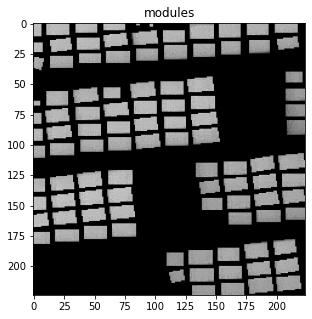

In [9]:
# モジュール抽出画像
img_mask = cv2.bitwise_and(img_org, img_con)
utils.show_img({"modules":img_mask},cmap="gray",figsize=(5,5))

In [10]:
# 画像の出力
img_write = cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index_no_dbscan.png',img_write)

True

モジュール候補のクラスタリング

In [11]:
# クラスタのラベルを取得
modules = Modules(candidate_module_contours)
module_labels = modules.get_dbscan_labels(candidate_module_contours, eps=1.25)
print(module_labels)

[ 0  1  2  3  0  0  1  2  3  0  0  1  2  3  4  4  5  6  4  7  4  8  5  9
  6 10  4  7  4  8  9  5  6 10  7  4  4  8  9  5  6 10  7  8  9 11 11 12
 13 14 15 16 11 11 12 13 17 14 15 16 11 11 12 17 13 14 11 15 16 11 17 12
 13 14 15 16 17 18 18 19 20 20 -1 -1 18 -1 -1 18 -1 19 20 20 -1 -1 -1 -1
 -1 20 20 20 19 18 18]


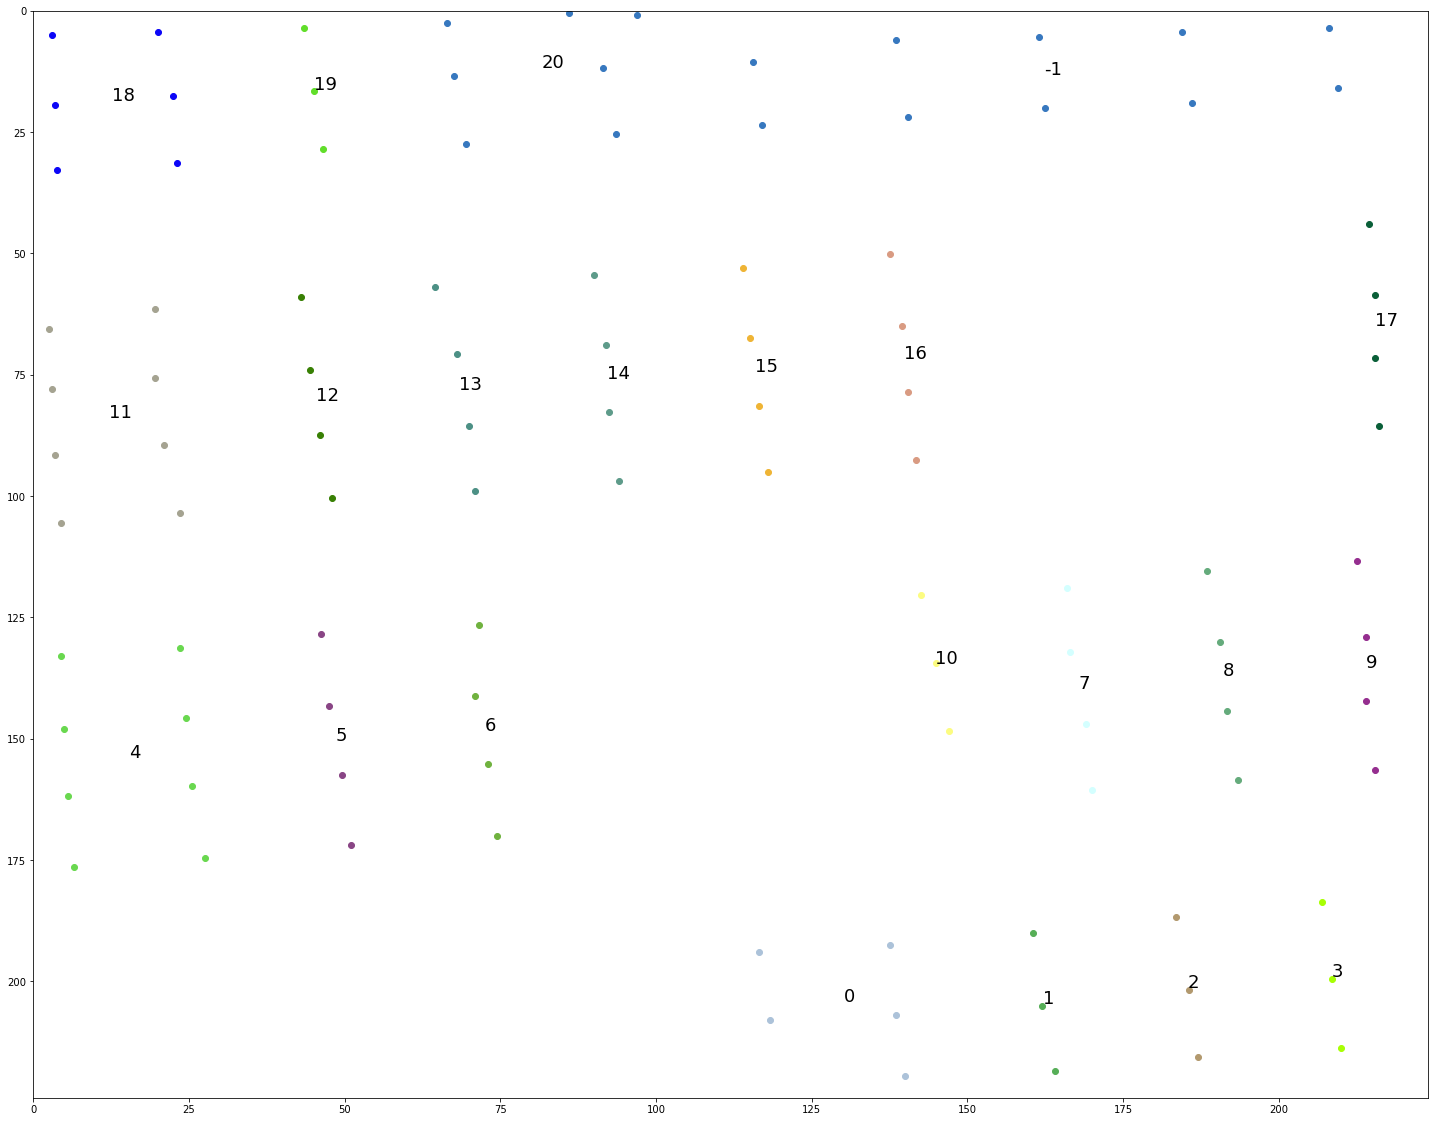

In [12]:
module_extraction.plot_module_map_with_labels(img_org, candidate_module_contours, module_labels)

サイズが大きいクラスタのみを残す

In [13]:
from collections import Counter
counter = Counter(module_labels)

In [14]:
counter.most_common

<bound method Counter.most_common of Counter({-1: 10, 4: 8, 11: 8, 20: 7, 18: 6, 0: 5, 5: 4, 6: 4, 7: 4, 8: 4, 9: 4, 12: 4, 13: 4, 14: 4, 15: 4, 16: 4, 17: 4, 1: 3, 2: 3, 3: 3, 10: 3, 19: 3})>

In [15]:
n_threshold = 1
group_labels = np.array([i for (i, count) in counter.most_common() if i>0 and count>n_threshold])
group_flags = [label in group_labels for label in module_labels]

In [16]:
# クラスタのラベルを取得
module_contours = np.array(candidate_module_contours)[group_flags]
modules = Modules(module_contours) # 真のモジュール情報に更新
module_labels = modules.get_dbscan_labels(module_contours, eps=1.25)

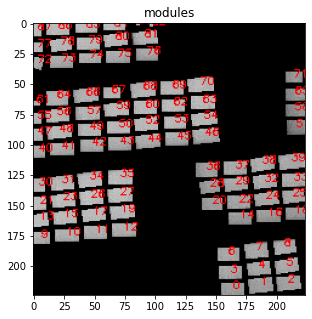

In [17]:
# モジュール抽出画像
img_con = modules.get_img_contours(img_org, index=False)
img_mask = cv2.bitwise_and(img_org, img_con)
img_mask_index = modules.add_index(img_mask)
utils.show_img({"modules":img_mask_index},cmap="gray",figsize=(5,5))

In [18]:
# 画像の出力
img_write = cv2.cvtColor(img_mask_index, cv2.COLOR_BGR2RGB)
cv2.imwrite(output_dir_path+'/img_mask_index.png',img_write)

True

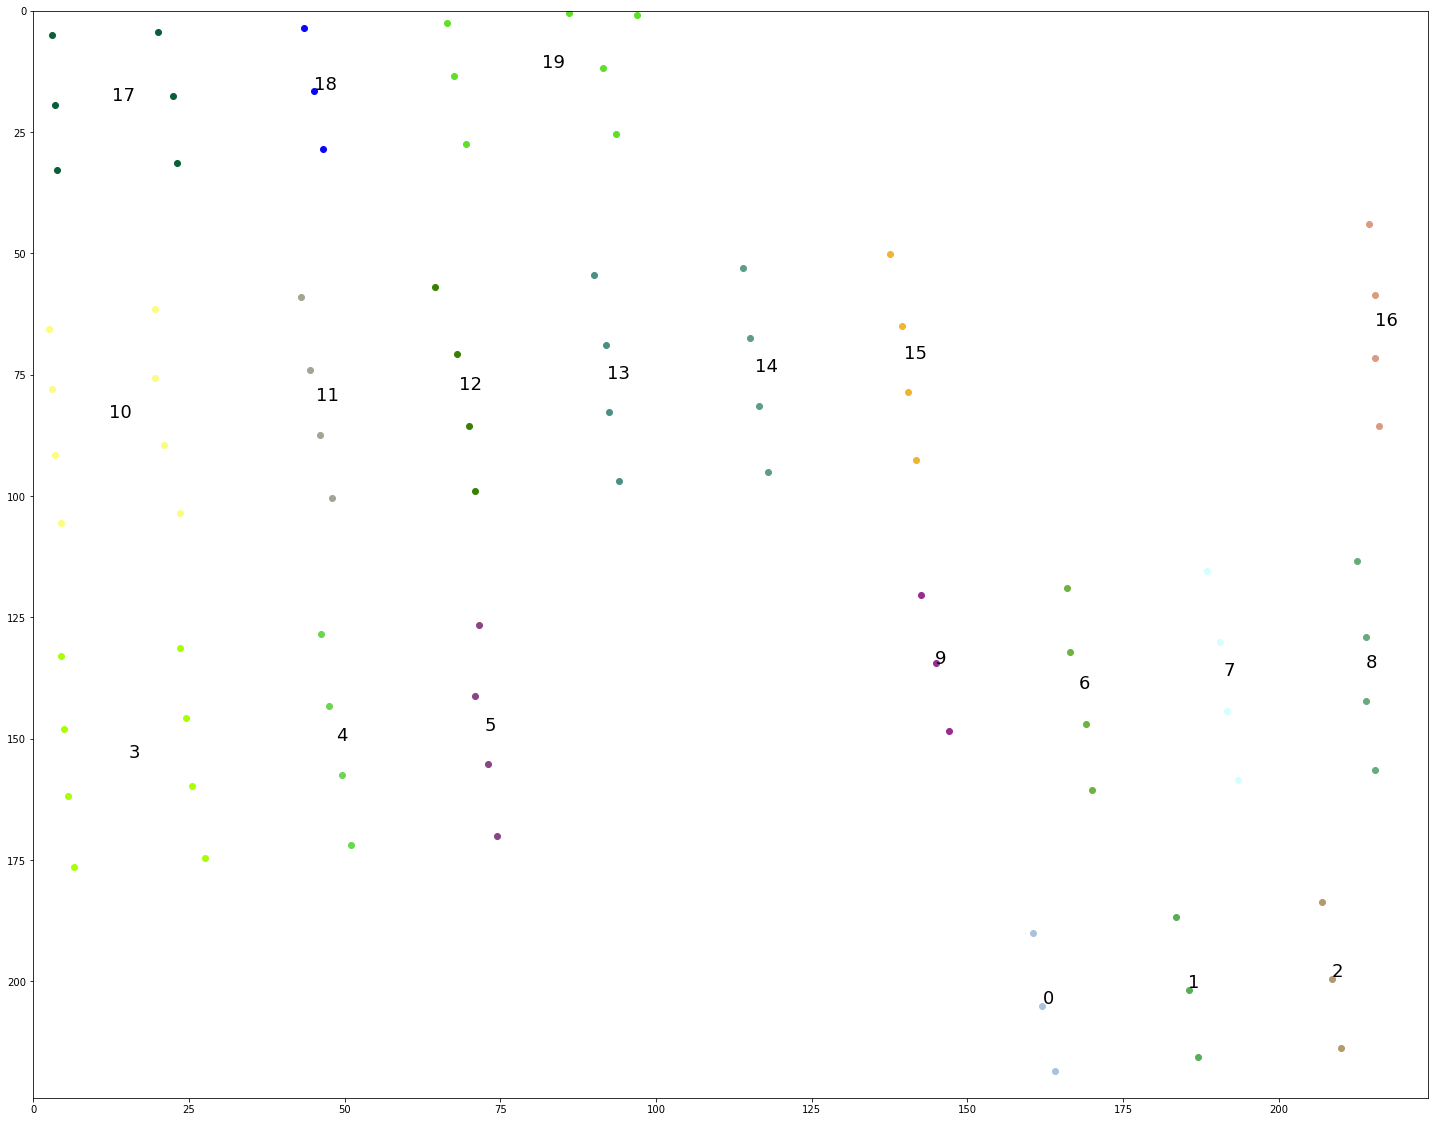

In [19]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, module_labels)

In [20]:
desired_cluster_size = 50

In [21]:
splitted_module_labels = module_extraction.split_module_labels(
    module_contours, module_labels, desired_cluster_size)

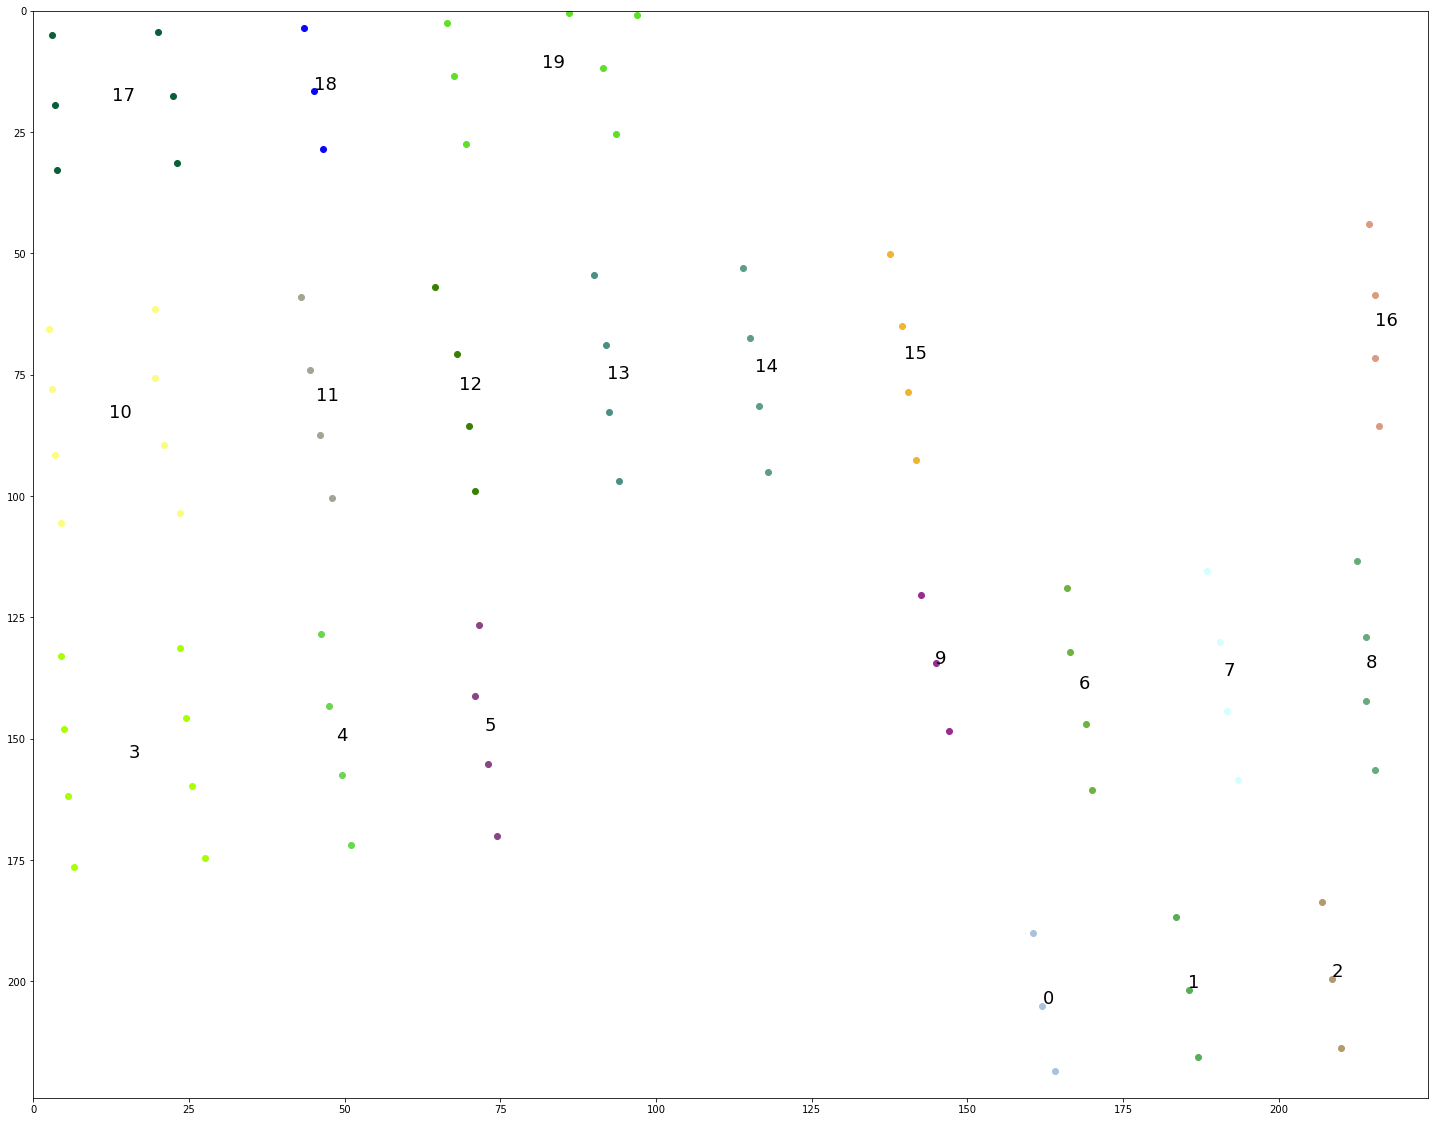

In [22]:
module_extraction.plot_module_map_with_labels(img_org, module_contours, splitted_module_labels)

In [23]:
# モジュール画像の切り出し＆保存
modules.extract_modules(img_org, output_dir_path)

In [24]:
# モジュール輪郭情報とラベルの保存
with open(output_dir_path+'/module_contours.pkl', 'wb') as pkl:
    pickle.dump(module_contours, pkl)
with open(output_dir_path+'/module_labels.pkl', 'wb') as pkl:
    pickle.dump(module_labels, pkl)    
with open(output_dir_path+'/module_labels_split.pkl', 'wb') as pkl:
    pickle.dump(splitted_module_labels, pkl) 